In [113]:
library("EpiEstim")
library("lubridate")
library("tidyverse")
library("CausalImpact")

Aquí alisto factores, fechas y cambio el origen a local e importado como los necesita EpiEstim:

In [114]:
Mex <- read.csv("https://raw.githubusercontent.com/marianarf/covid19_mexico_analysis/master/covid_mex_20200401.csv")
Mex$Date_Confirmed <- mdy(as.character(Mex$Date_Confirmed))
Mex$Date_Symptoms <- mdy(as.character(Mex$Date_Symptoms))
Mex$Origin <- if_else(Mex$Origin=="Contacto","local","imported")
Mex$Origin <- as.factor(Mex$Origin)

In [115]:
head(Mex)

,Case_ID,Region,Sex,Age,Date_Symptoms,Tested,Origin,Date_Arrival,Date_Confirmed,Inconsistent,Inconsistent_New_Date,Omission,Omission_Last_Date
,<int>,<fct>,<fct>,<int>,<date>,<fct>,<fct>,<fct>,<date>,<int>,<fct>,<int>,<fct>
1,1,CIUDAD DE MÉXICO,M,35,2020-02-22,confirmado,imported,2/22/2020,2020-02-27,0,NA,0,NA
2,2,SINALOA,M,41,2020-02-22,confirmado,imported,2/21/2020,2020-02-28,0,NA,0,NA
3,3,CIUDAD DE MÉXICO,M,59,2020-02-23,confirmado,imported,2/22/2020,2020-02-29,0,NA,0,NA
4,4,COAHUILA,F,20,2020-02-27,confirmado,imported,2/25/2020,2020-02-29,0,NA,0,NA
5,5,CHIAPAS,F,18,2020-02-25,confirmado,imported,2/25/2020,2020-03-01,0,NA,0,NA
6,6,MÉXICO,M,71,2020-02-21,confirmado,imported,2/21/2020,2020-03-06,0,NA,0,NA


Limpieza y Wrangling de los datos:

In [118]:
Mex_Clean_arriba50 <- Mex %>% 
  dplyr::select(-c(Tested,Age,Sex,Inconsistent,Inconsistent_New_Date,Omission,
            Omission_Last_Date,Date_Arrival,Case_ID)) %>% 
  group_by(Region,Date_Symptoms,Origin) %>% 
  summarise(casos = n())  %>% 
  ungroup() %>% 
  group_by(Region,Origin) %>% 
  mutate(acumulado = cumsum(casos))%>% 
  ungroup() %>% 
  group_by(Region) %>% 
  mutate(max = sum(casos)) %>% 
  filter(max > 50) %>% 
  dplyr::select(-c(max,casos)) %>% 
  ungroup() %>% 
  rename(Estado = Region, 
         dates = Date_Symptoms, 
         Origen = Origin, 
         Incidencia = acumulado)

In [119]:
head(Mex_Clean_arriba50,15)

Estado,dates,Origen,Incidencia
<fct>,<date>,<fct>,<int>
CIUDAD DE MÉXICO,2020-02-17,local,1
CIUDAD DE MÉXICO,2020-02-22,imported,1
CIUDAD DE MÉXICO,2020-02-23,imported,2
CIUDAD DE MÉXICO,2020-02-29,imported,3
CIUDAD DE MÉXICO,2020-03-01,imported,4
CIUDAD DE MÉXICO,2020-03-02,imported,5
CIUDAD DE MÉXICO,2020-03-03,imported,6
CIUDAD DE MÉXICO,2020-03-04,imported,8
CIUDAD DE MÉXICO,2020-03-06,imported,10


In [120]:
Fechas <- rep(seq(min(Mex_Clean_arriba50$dates),max(Mex_Clean_arriba50$dates), by = "day"),length(unique(Mex_Clean_arriba50$Estado)))
Fechas_2 <- rep(Fechas,2)
Orig <- c(rep("local",length(Fechas)),rep("imported",length(Fechas)))
l <- length(seq(min(Mex_Clean_arriba50$dates),max(Mex_Clean_arriba50$dates), by = "day"))
estado <- c()
for (est in unique(Mex_Clean_arriba50$Estado)){
  estado <- c(estado, rep(est,l))
    }



helper <- tibble(
    Origen = as.factor(Orig),
    dates = Fechas_2,
    Estado = as.factor(rep(estado,2))
    )

In [121]:
Mex_filled <- Mex_Clean_arriba50 %>% 
    right_join(helper)

Joining, by = c("Estado", "dates", "Origen")

Warning message:
“Column `Estado` joining factors with different levels, coercing to character vector”


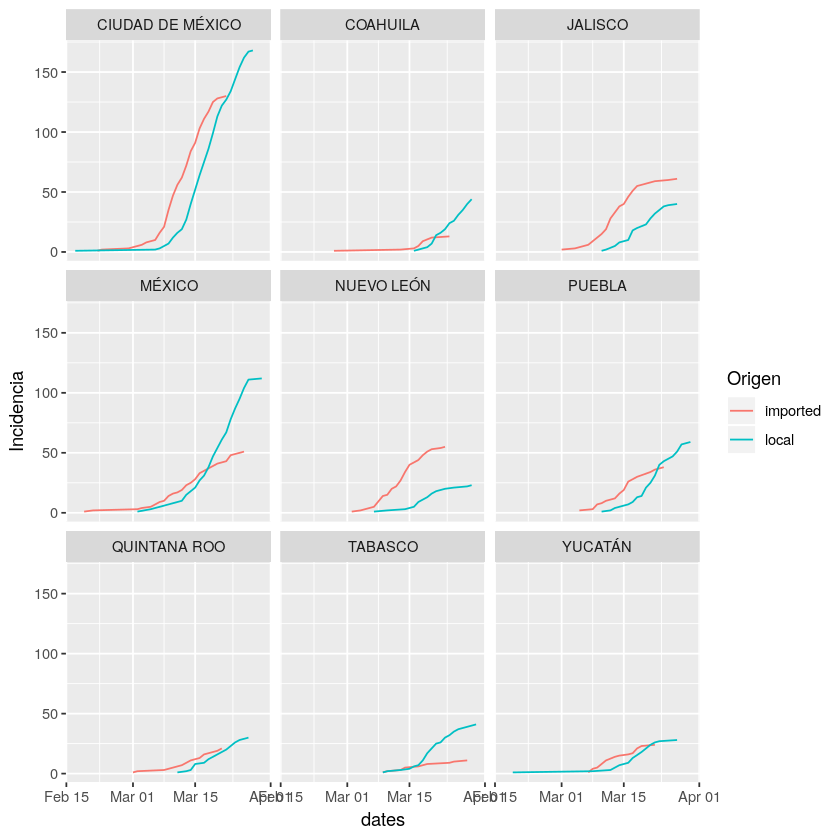

In [122]:
Mex_Clean_arriba50 %>% 
  ggplot(aes(x=dates,y=Incidencia,color=Origen))+geom_line()+facet_wrap(~Estado)
                                                                         
# Los outputs gráficos de R en jupyter siempre son horribles.                                                                        

Configuración del **SERIAL INTERVAL** según la referencia que paso lalito:

In [123]:
config <- make_config(list(mean_si = 4.7, std_mean_si = 0.5,
                           min_mean_si = 3.4, max_mean_si = 6.0,
                           std_si = 2.9, std_std_si = 0.6,
                           min_std_si = 1.9, max_std_si = 3.9))

Corrida como ejemplo de JALISCO:

* aquí me gustaría que hubiera un dropdown menú que puede seleccionar entre estos estados:

In [124]:
unique(Mex_Clean_arriba50$Estado) # esta linea diera las opciones del dropdown menú

[1] CIUDAD DE MÉXICO COAHUILA         JALISCO          MÉXICO          
[5] NUEVO LEÓN       PUEBLA           QUINTANA ROO     TABASCO         
[9] YUCATÁN         
33 Levels: AGUASCALIENTES BAJA CALIFORNIA ... ZACATECAS

suponemos seleccionamos uno:

In [125]:
state = "JALISCO"

se muestran casos importados y locales:

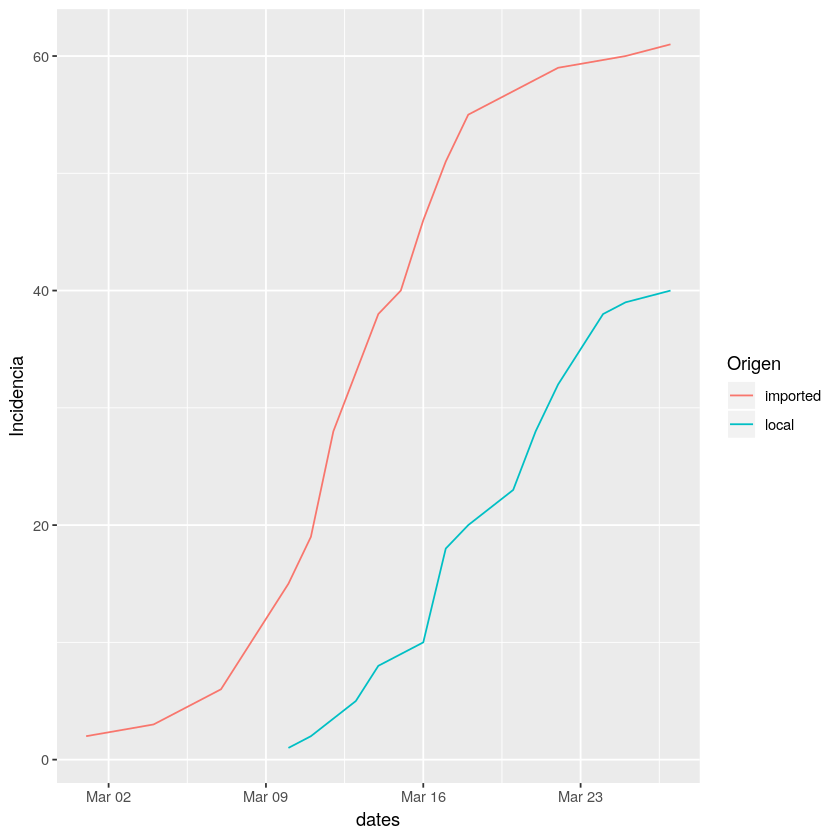

In [126]:
Mex_Clean_arriba50 %>% 
  filter(Estado == state) %>%
  ggplot(aes(x=dates,y=Incidencia,color=Origen))+geom_line()

Se obtiene y muestra Grafico de R instantaneo:

In [128]:
R <- Mex_filled %>% 
  spread(Origen,Incidencia) %>% 
  filter(Estado == state) %>% 
  dplyr::select(c(dates,local,imported)) %>% 
  ungroup() %>%
  mutate(local = replace_na(local, 0)) %>% 
  mutate(imported = replace_na(imported, 0)) %>% 
  estimate_R(.,method = "uncertain_si", config = config)

R <- R$R

Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

Warning message in estimate_R_func(incid = incid, method = method, si_sample = si_sample, :
“You're estimating R too early in the epidemic to get the desired
            posterior CV.”


Aquí podriamos mejorar el plot poniendo las fechas no el numero de semana que le asigna EpiEstim!

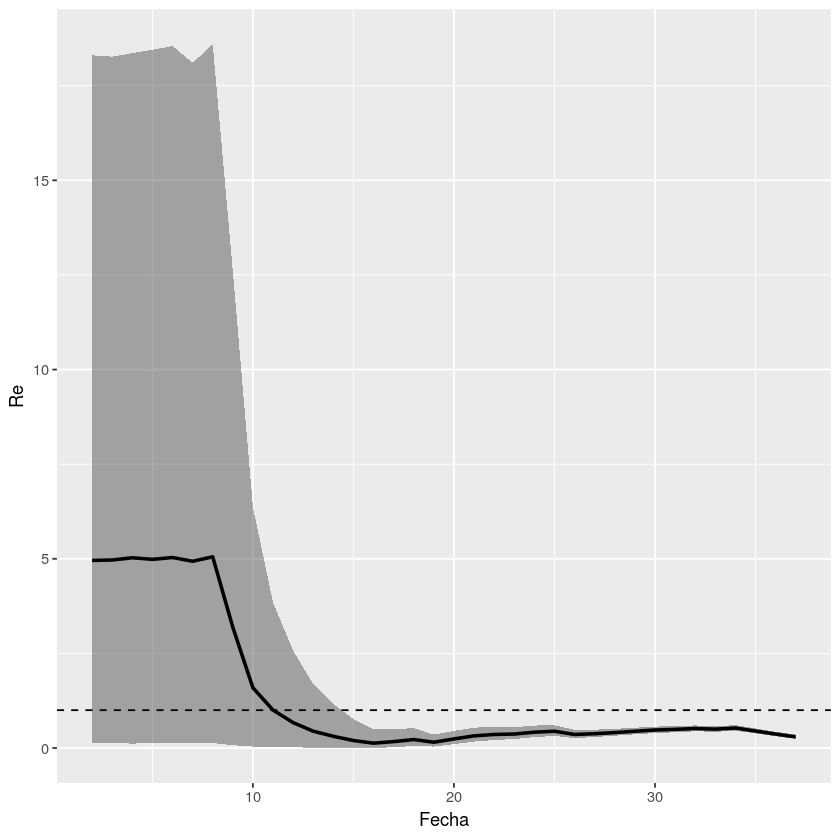

In [129]:
R%>%
  dplyr::select(Fecha = t_start, Re = `Mean(R)`, Q1 = `Quantile.0.025(R)`, Q3 = `Quantile.0.975(R)`) %>%
  ggplot(., aes(x = Fecha)) +
  geom_ribbon(aes(ymin = Q1, ymax = Q3), alpha = 0.4) +
  geom_line(aes(y = Re), lwd = 1) +
  geom_hline(yintercept = 1, linetype = "dashed")

Se obtiene R instantaneo promedio, y sus cuantiles:

In [130]:
Re_mean = mean(R$`Mean(R)`)
Re_Q1 = mean(R$`Quantile.0.05(R)`)
Re_Q2 = mean(R$`Quantile.0.95(R)`)

Necesitamos scrappear info de poblacion por estado, para rellenar la variable population dado el estado.

In [131]:
Pop <- 8000000 #slider???

I <- Mex_Clean_arriba50 %>%
    filter(Estado == state & Origen == "imported") %>%
    summarise(max(Incidencia)) + Mex_Clean_arriba50 %>%
    filter(Estado == state & Origen == "local") %>%
    summarise(max(Incidencia))

#Estas están asumiendo el dia de los sintómas del últímo reportado, 
#habría que ver como darle el feed de los datos más actuales por ejemplo en jalisco a dia de hoy hay 135 casos, no 101.

I<- I$`max(Incidencia)`/Pop
E = I*4 #asumimos a 4 expuestos por persona
A = I*0.18
R = 0 / Pop # como rellenamos esto? slider?
D = 0 / Pop # lo mismo que el de arriba?
S = 1-(I+E+A+R+D)

R0_mean = Re_mean / S
R0_97 = Re_Q2 / S
R0_2 = Re_Q1 / S
#Parámetros de ODEs 

gamma = 0.1 #suponiendo una recuperación de 10 dias slider?
alpha = 0.2 #suponiendo una incubación de 5 dias slider?
beta = R0_mean*gamma
beta_97 = R0_97*gamma
beta_2 = R0_2*gamma
rho = 0.82 # suponiendo que el 18% de los infectados es asintomático

GetBeta <- function(intervencion){
    switch(intervencion, "base" = beta,"97.5" = beta_97, "2.5" = beta_2, "moderada" = beta - (beta*0.25), "agresiva" = beta/2)    
}

In [132]:
paste("the value of R0 is ", round(R0_mean,2)) # ponerlo en algun panelito bonito
paste("the value of R0(97.5%) is ", round(R0_97,2)) # ponerlo en algun panelito bonito
paste("the value of R0(2.5%) is ", round(R0_2,2)) # ponerlo en algun panelito bonito

[1] "the value of R0 is  1.4"

[1] "the value of R0(97.5%) is  3.85"

[1] "the value of R0(2.5%) is  0.23"

In [133]:
Condiciones_Iniciales = c(S,E,A,I,R)
pmtrs = c(gamma,alpha,rho)
t = seq(0, 120, by=0.1) #tiempo de 120 dias

In [134]:
SEAIRD <- function(IC,pmtrs,t, basal = "base", intervencion = "base", init_intervention = 1, intervention_period = 119){
    
    Sv <- c(IC[1])
    Ev <- c(IC[2])
    Av <- c(IC[3])
    Iv <- c(IC[4])
    Rv <- c(IC[5])
    
    dt= t[2]-t[1]
    
    for (i in t[2:length(t)]){
        if (i>= init_intervention & i <= (init_intervention+intervention_period))
        {
            beta = GetBeta(intervencion)
            }
        else
        {
            beta = GetBeta(basal)
            }
        
        S <- Sv[length(Sv)]
        I <- Iv[length(Iv)]
        E <- Ev[length(Ev)]
        A <- Av[length(Av)]
        
        
        St <- S - (beta*S*I)*dt
        Et <- E + (beta*S*I - pmtrs[2]*E)*dt
        At <- A + (1-pmtrs[3])*(pmtrs[2]*E - pmtrs[1]*A)*dt
        It <- I + (pmtrs[3])*(pmtrs[2]*E - pmtrs[1]*I)*dt
        Rt <- (1 - (S-E-A-I))
            
        Sv <- c(Sv,St)
        Ev <- c(Ev,Et)
        Av <- c(Av,At)
        Iv <- c(Iv,It)
        Rv <- c(Rv,Rt)
            }
    ODE <- list("Suceptibles" = Sv, "Expuestos" = Ev, "Asintomáticos" = Av, 
              "Infectados" = Iv, "Recuperados" = Rv)
    return(ODE)    
    }  

In [135]:
ODE <- SEAIRD(Condiciones_Iniciales,pmtrs,t)
ODE97 <- SEAIRD(Condiciones_Iniciales,pmtrs,t, intervencion = "97.5")
ODE2 <- SEAIRD(Condiciones_Iniciales,pmtrs,t, intervencion = "2.5")

In [136]:
ODE_m <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "base", intervencion = "moderada")
ODE97_m <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "97.5", intervencion = "moderada")
ODE2_m <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "2.5", intervencion = "moderada")

In [137]:
ODE_f <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "base", intervencion = "agresiva")
ODE97_f <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "97.5", intervencion = "agresiva")
ODE2_f <- SEAIRD(Condiciones_Iniciales,pmtrs,t, basal = "2.5", intervencion = "agresiva")

INFECTADOS: 

Checar xlim y ylim para que la figura quede bien, como el quantil 97 es muy grande, no deja ver nada, así que lo cortamos, lo mismo a xlim, una frontera de 20 dias

Casos graves asumiendo el 2%

In [138]:
Infectados_df <- tibble(
    Dias = rep(as_date(seq(today(),today()+119, by = "day")),3),
    "Infectados" = c(ODE$Infectados[c(seq(0,120,1))]*Pop,ODE_m$Infectados[c(seq(0,120,1))]*Pop,ODE_f$Infectados[c(seq(0,120,1))]*Pop),
    "Infectados(97.5%)" = c(ODE97$Infectados[c(seq(0,120,1))]*Pop,ODE97_m$Infectados[c(seq(0,120,1))]*Pop,ODE97_f$Infectados[c(seq(0,120,1))]*Pop),
    "Infectados(2.5%)" = c(ODE2$Infectados[c(seq(0,120,1))]*Pop,ODE2_m$Infectados[c(seq(0,120,1))]*Pop,ODE2_f$Infectados[c(seq(0,120,1))]*Pop),
    "Intervencion" = factor(c(rep("Base",length(ODE97$Infectados[c(seq(0,120,1))])),rep("Moderada",length(ODE97$Infectados[c(seq(0,120,1))])),rep("Agresiva",length(ODE97$Infectados[c(seq(0,120,1))]))), levels = c("Base","Moderada","Agresiva"))
)

Graves_df <- tibble(
    Dias = rep(as_date(seq(today(),today()+119, by = "day")),3),
    "Casos Graves" = c(ODE$Infectados[c(seq(0,120,1))]*Pop*.02,ODE_m$Infectados[c(seq(0,120,1))]*Pop*.02,ODE_f$Infectados[c(seq(0,120,1))]*Pop*.02),
    "Casos Graves(97.5%)" = c(ODE97$Infectados[c(seq(0,120,1))]*Pop*.02,ODE97_m$Infectados[c(seq(0,120,1))]*Pop*.02,ODE97_f$Infectados[c(seq(0,120,1))]*Pop*.02),
    "Casos Graves(2.5%)" = c(ODE2$Infectados[c(seq(0,120,1))]*Pop*.02,ODE2_m$Infectados[c(seq(0,120,1))]*Pop*.02,ODE2_f$Infectados[c(seq(0,120,1))]*Pop*.02),
    "Intervencion" = factor(c(rep("Base",length(ODE97$Infectados[c(seq(0,120,1))])),rep("Moderada",length(ODE97$Infectados[c(seq(0,120,1))])),rep("Agresiva",length(ODE97$Infectados[c(seq(0,120,1))]))), levels = c("Base","Moderada","Agresiva"))
)

Asintomaticos_df <- tibble(
    Dias = rep(as_date(seq(today(),today()+119, by = "day")),3),
    "Asintomaticos" = c(ODE$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE_m$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE_f$`Asintomáticos`[c(seq(0,120,1))]*Pop),
    "Asintomaticos(97.5%)" = c(ODE97$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE97_m$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE97_f$`Asintomáticos`[c(seq(0,120,1))]*Pop),
    "Asintomaticos(2.5%)" = c(ODE2$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE2_m$`Asintomáticos`[c(seq(0,120,1))]*Pop,ODE2_f$`Asintomáticos`[c(seq(0,120,1))]*Pop),
    "Intervencion" = factor(c(rep("Base",length(ODE97$`Asintomáticos`[c(seq(0,120,1))])),rep("Moderada",length(ODE97$`Asintomáticos`[c(seq(0,120,1))])),rep("Agresiva",length(ODE97$`Asintomáticos`[c(seq(0,120,1))]))), levels = c("Base","Moderada","Agresiva"))
)


# Infectados

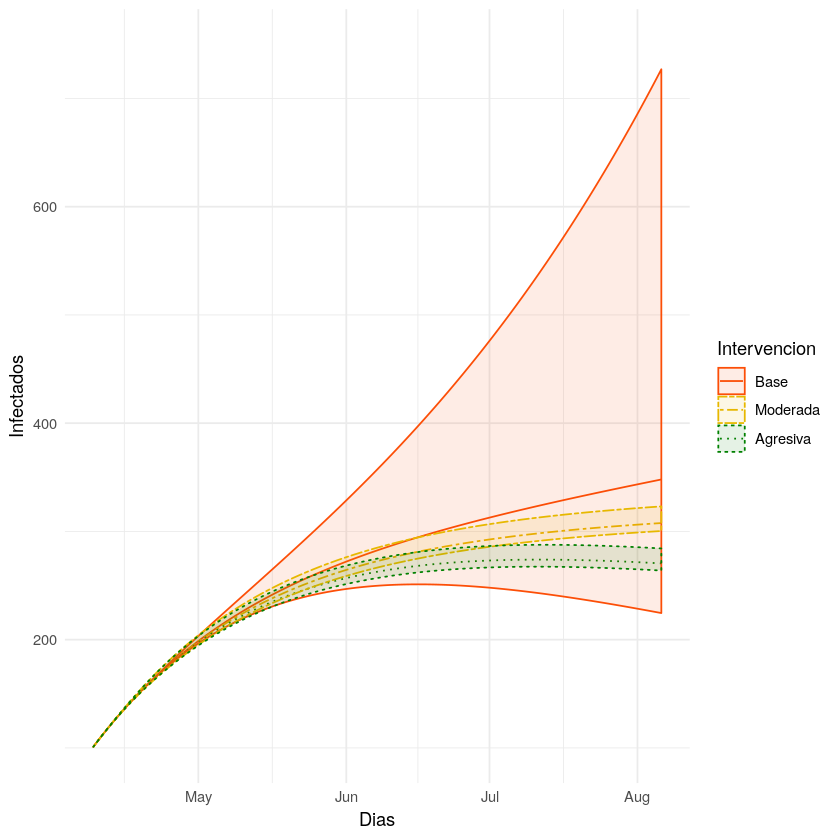

In [140]:
Infectados_df%>%
  dplyr::select(Dias,Infectados, Q2 = `Infectados(97.5%)`, Q1 = `Infectados(2.5%)`, Intervencion = Intervencion) %>%
  ggplot(., aes(x = Dias, y = Infectados , color = Intervencion , linetype = Intervencion)) + geom_line(lwd = 0.5)+
  geom_ribbon(aes(ymin = Q1, ymax = Q2, fill = Intervencion), alpha = 0.1) + 
  scale_linetype_manual(values=c("solid","twodash", "dotted")) + 
  scale_color_manual(values = c("#FC4E07", "#E7B800", "#008000")) +  
  scale_fill_manual(values = c("#FC4E07", "#E7B800", "#008000")) + ylim(100,750) + theme_minimal()

# ASINTOMATICOS O NO REPORTADOS
* Checar escalas de nuez

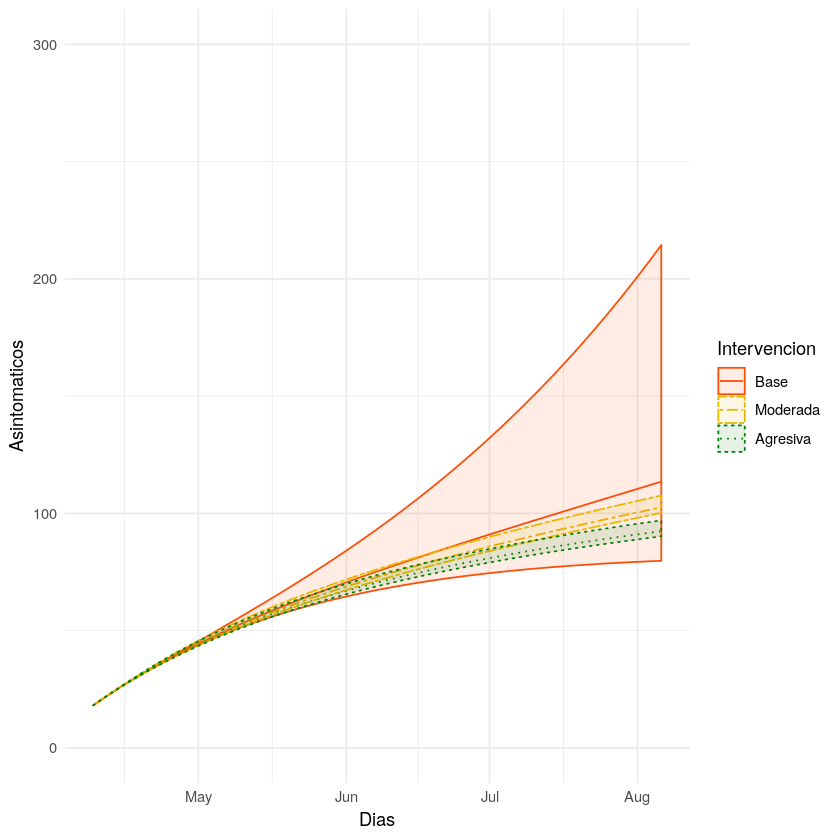

In [141]:
Asintomaticos_df%>%
  dplyr::select(Dias,`Asintomaticos`, Q2 = `Asintomaticos(97.5%)`, Q1 = `Asintomaticos(2.5%)`, Intervencion = Intervencion) %>%
  ggplot(., aes(x = Dias, y = Asintomaticos, color = Intervencion , linetype = Intervencion)) + geom_line(lwd = 0.5)+
  geom_ribbon(aes(ymin = Q1, ymax = Q2, fill = Intervencion), alpha = 0.1) + 
  scale_linetype_manual(values=c("solid","twodash", "dotted")) + 
  scale_color_manual(values = c("#FC4E07", "#E7B800", "#008000")) +  
  scale_fill_manual(values = c("#FC4E07", "#E7B800", "#008000")) + ylim(0,300) + theme_minimal()

Casos graves 

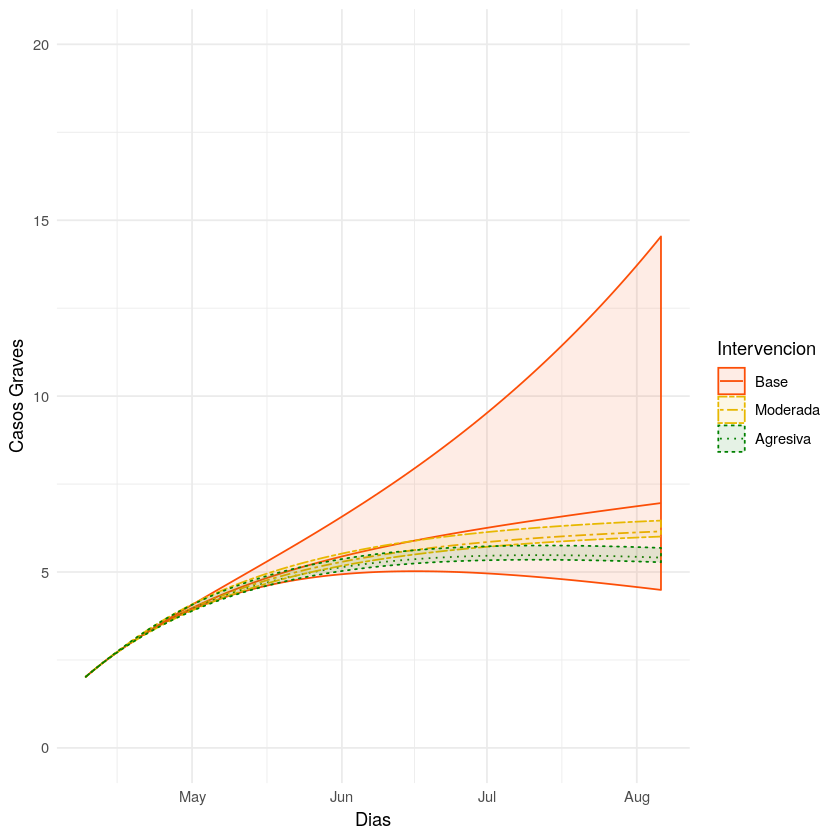

In [142]:
Graves_df%>%
  dplyr::select(Dias,`Casos Graves`, Q2 = `Casos Graves(97.5%)`, Q1 = `Casos Graves(2.5%)`, Intervencion = Intervencion) %>%
  ggplot(., aes(x = Dias, y = `Casos Graves`, color = Intervencion , linetype = Intervencion)) + geom_line(lwd = 0.5)+
  geom_ribbon(aes(ymin = Q1, ymax = Q2, fill = Intervencion), alpha = 0.1) + 
  scale_linetype_manual(values=c("solid","twodash", "dotted")) + 
  scale_color_manual(values = c("#FC4E07", "#E7B800", "#008000")) +  
  scale_fill_manual(values = c("#FC4E07", "#E7B800", "#008000")) + ylim(0,20) + theme_minimal()

Suponiendo que el virus genera un 100% de inmunidad, el porcentaje de la población que se tiene que contagiar para contener la epidemia aún es del:

In [143]:
(1 - (1/R0_mean)) * 100 

[1] 28.57496